## Loan Approval Prediction
https://www.kaggle.com/competitions/playground-series-s4e10

#### Contents:
1. Introduction
2. Data Exploration
3. Data Processing
4. Machine Learning
5. Evaluation




#### 1. Introduction

Your Goal: The goal for this competition is to predict whether an applicant is approved for a loan.

Submissions are evaluated using area under the ROC curve using the predicted probabilities and the ground truth targets.

The Data:
The data set contains 23 columns consisting  binary, categorical and numerical values. The target value is called loan_status and is a binary value being either 1 or 0. The other columns are as followed:

Numerical:\
Id\
Person_age\
Person_income\
Person_emp_lenght\
Loan_amnt\
Loan_int_rate\
Loan_percent_income\
cb_person_cred_hist_length

Categorical:\
Person_home_ownership\
Loan_intent\
Loan_grade\
cb_person_default_on_file






In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import xgboost as xgb

from sklearn.metrics import roc_auc_score
# ROC is used for evaluation of model

In [45]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_output = pd.DataFrame()
df_output['id'] = df_test['id'].copy()

In [46]:
df_train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


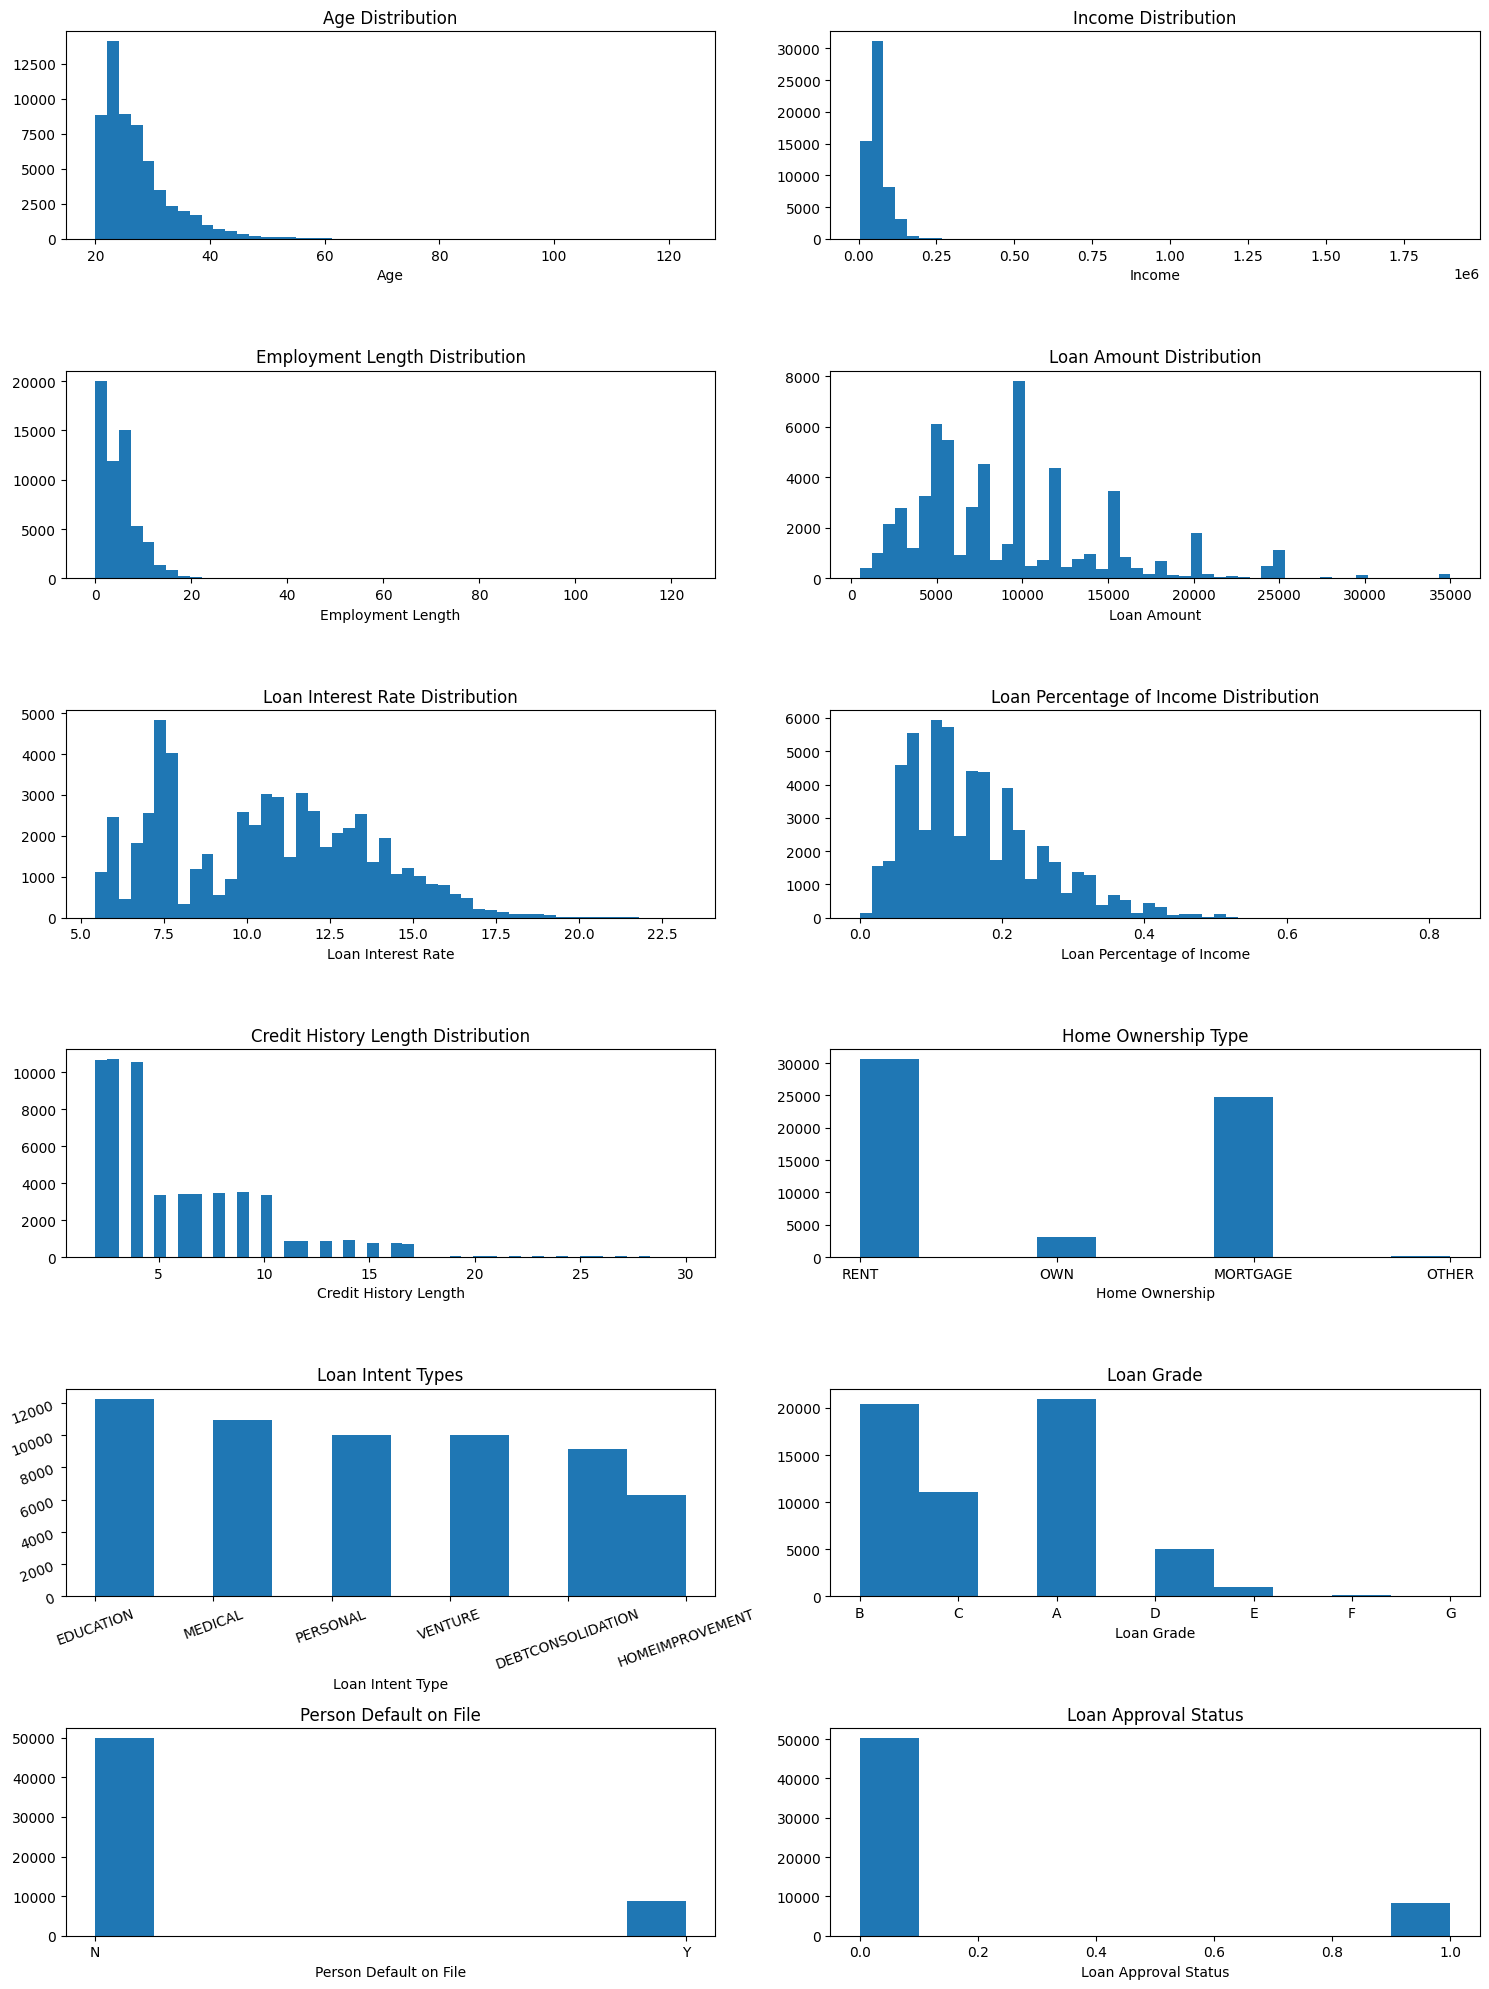

In [47]:
fig, ax = plt.subplots(6, 2, figsize=(15, 20))
ax[0,0].hist(df_train['person_age'], bins=50)
ax[0,0].set(xlabel = 'Age')
ax[0,0].set_title('Age Distribution')
ax[0,1].hist(df_train['person_income'], bins=50)
ax[0,1].set(xlabel = 'Income')
ax[0,1].set_title('Income Distribution')
ax[1,0].hist(df_train['person_emp_length'], bins=50)
ax[1,0].set(xlabel = 'Employment Length')
ax[1,0].set_title('Employment Length Distribution')
ax[1,1].hist(df_train['loan_amnt'], bins=50)
ax[1,1].set(xlabel = 'Loan Amount')
ax[1,1].set_title('Loan Amount Distribution')
ax[2,0].hist(df_train['loan_int_rate'], bins=50)
ax[2,0].set(xlabel = 'Loan Interest Rate')
ax[2,0].set_title('Loan Interest Rate Distribution')
ax[2,1].hist(df_train['loan_percent_income'], bins=50)
ax[2,1].set(xlabel = 'Loan Percentage of Income')
ax[2,1].set_title('Loan Percentage of Income Distribution')
ax[3,0].hist(df_train['cb_person_cred_hist_length'], bins=50)
ax[3,0].set(xlabel = 'Credit History Length')
ax[3,0].set_title('Credit History Length Distribution')
ax[3,1].hist(df_train['person_home_ownership'])
ax[3,1].set(xlabel = 'Home Ownership')
ax[3,1].set_title('Home Ownership Type')
ax[4,0].hist(df_train['loan_intent'])
ax[4,0].set(xlabel = 'Loan Intent Type')
ax[4,0].set_title('Loan Intent Types')
ax[4,0].tick_params(labelrotation=20)
ax[4,1].hist(df_train['loan_grade'])
ax[4,1].set(xlabel = 'Loan Grade')
ax[4,1].set_title('Loan Grade')
ax[5,0].hist(df_train['cb_person_default_on_file'])
ax[5,0].set(xlabel = 'Person Default on File')
ax[5,0].set_title('Person Default on File')
ax[5,1].hist(df_train['loan_status'])
ax[5,1].set(xlabel = 'Loan Approval Status')
ax[5,1].set_title('Loan Approval Status')
fig.tight_layout()

<Axes: >

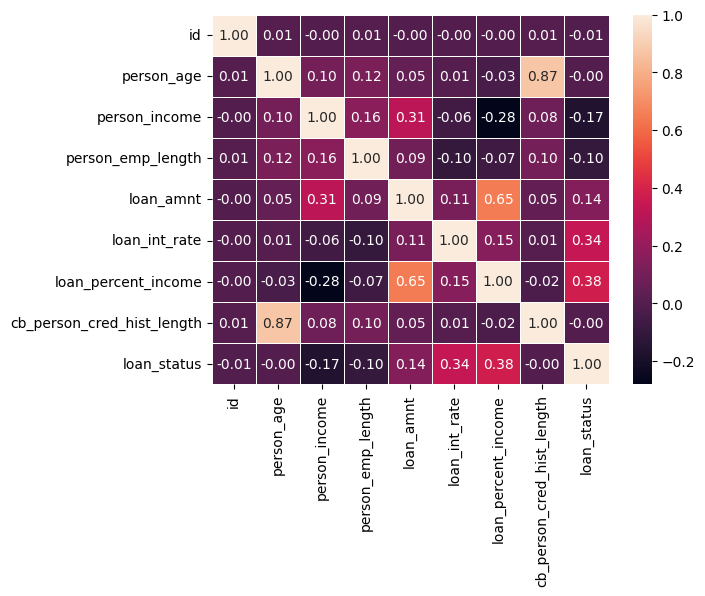

In [48]:
df_numeric  = df_train.select_dtypes('number').corr()
sns.heatmap(df_numeric, 
            xticklabels=df_numeric.columns,
            yticklabels=df_numeric.columns,
            annot=True, 
            linewidth=.5, 
            fmt='.2f')


In [49]:
def remove_outliers(df : pd.DataFrame, columns : list, significance: int):
    for column in columns:
        upperLimit = df[column].quantile(1-significance*.01)
        lowerLimit = df[column].quantile(significance*.01)
        df = df.loc[(df[column] > lowerLimit) & (df[column] < upperLimit)]
    return df

def normalize_data(df : pd.DataFrame, columns : list):
    for column in columns:
        df[column] = df[column] / df[column].abs().max() 
    return df

def create_dummies(df : pd.DataFrame, columns : list):
    for column in columns:
        df = pd.concat([df.drop(column, axis=1), pd.get_dummies(df[column], prefix=column)], axis=1)
    return df

In [50]:
columns_outliers = ['person_income', 'person_age', 'person_emp_length', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
columns_normalization = ['person_income', 'person_age', 'person_emp_length', 'loan_percent_income', 'cb_person_cred_hist_length']
columns_dummies = ['person_home_ownership', 'loan_intent', 'loan_grade']

#df_train = remove_outliers(df_train, columns_outliers, 1)
df_train = normalize_data(df_train, columns_normalization)
df_train = create_dummies(df_train, columns_dummies)
df_train['cb_person_default_on_file'] = df_train['cb_person_default_on_file'].map(dict(Y=1, N=0))

df_test = normalize_data(df_test, columns_normalization)
df_test = create_dummies(df_test, columns_dummies)
df_test['cb_person_default_on_file'] = df_test['cb_person_default_on_file'].map(dict(Y=1, N=0))

In [51]:
df_train['loan_status'].value_counts()

loan_status
0    50295
1     8350
Name: count, dtype: int64

In [52]:
# Balance Dataset by oversampling
minority_class = df_train[df_train['loan_status'] == 1]
majority_class = df_train[df_train['loan_status'] == 0]


minority_upsampled = resample(minority_class, replace=True, n_samples=len(majority_class), random_state=42)
df_train = pd.concat([majority_class, minority_upsampled])

In [53]:
df_train.drop(columns='loan_amnt', inplace=True)
df_test.drop(columns='loan_amnt', inplace=True)

In [54]:
df_train, df_validation = train_test_split(df_train, test_size=0.333, random_state=42)

In [55]:
clf = xgb.XGBClassifier(tree_method='hist',random_state=42)
clf.fit(df_train.loc[:, df_train.columns != 'loan_status'], df_train['loan_status'])
predictions = clf.predict(df_validation.loc[:, df_validation.columns != 'loan_status'])

In [56]:
roc_auc_score(df_validation['loan_status'],predictions)

0.9363291616810612

In [57]:
predictions_test = clf.predict(df_test)
df_output['loan_status'] = predictions_test
df_output = df_output.set_index('id')
df_output.to_csv('Predictions_v5.csv')
